In [1]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.1 MB/s eta 0:00:00


In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination

In [3]:
model = BayesianNetwork([
    ('Age', 'HeartDisease'),
    ('Smoking', 'HeartDisease'),
    ('Exercise', 'HeartDisease'),
    ('Cholesterol', 'HeartDisease'),
    ('BloodPressure', 'HeartDisease'),
    ('HeartDisease', 'ChestPain'),
    ('HeartDisease', 'ECGResult')
])

In [4]:
cpd_heart_disease = TabularCPD(
    variable='HeartDisease',
    variable_card=2,
    values=[
        [0.9, 0.8, 0.7, 0.6, 0.9, 0.8, 0.4,
         0.3, 0.8, 0.7, 0.6, 0.4, 0.7, 0.6,
         0.3, 0.2, 0.9, 0.8, 0.7, 0.5, 0.6,
         0.4, 0.3, 0.2, 0.7, 0.6, 0.4, 0.3,
         0.9, 0.8, 0.7, 0.5, 0.6, 0.4, 0.3,
         0.2, 0.9, 0.8, 0.7, 0.5, 0.6, 0.4,
         0.3, 0.2, 0.7, 0.6, 0.4, 0.3],
        [0.1, 0.2, 0.3, 0.4, 0.1, 0.2, 0.6,
         0.7, 0.2, 0.3, 0.4, 0.6, 0.3, 0.4,
         0.7, 0.8, 0.1, 0.2, 0.3, 0.5, 0.4,
         0.6, 0.7, 0.8, 0.3, 0.4, 0.6, 0.7,
         0.1, 0.2, 0.3, 0.5, 0.4, 0.6, 0.7,
         0.8, 0.1, 0.2, 0.3, 0.5, 0.4, 0.6,
         0.7, 0.8, 0.3, 0.4, 0.6, 0.7]
    ],
    evidence=['Age', 'Smoking', 'Exercise', 'Cholesterol', 'BloodPressure'],
    evidence_card=[3, 2, 2, 2, 2]
)

model.add_cpds(cpd_heart_disease)

In [5]:
cpd_age = TabularCPD(
    variable='Age',
    variable_card=3,
    values=[[0.3], [0.5], [0.2]]
)

cpd_chest_pain = TabularCPD(
    variable='ChestPain',
    variable_card=2,
    values=[[0.8, 0.3],
            [0.2, 0.7]],
    evidence=['HeartDisease'],
    evidence_card=[2]
)

cpd_smoking = TabularCPD(
    variable='Smoking',
    variable_card=2,
    values=[[0.4], [0.6]]
)

cpd_exercise = TabularCPD(
    variable='Exercise',
    variable_card=2,
    values=[[0.6], [0.4]]
)

cpd_cholesterol = TabularCPD(
    variable='Cholesterol',
    variable_card=2,
    values=[[0.7], [0.3]]
)

cpd_blood_pressure = TabularCPD(
    variable='BloodPressure',
    variable_card=2,
    values=[[0.6], [0.4]]
)

cpd_ecg_result = TabularCPD(
    variable='ECGResult',
    variable_card=2,
    values=[[0.9, 0.2],
            [0.1, 0.8]],
    evidence=['HeartDisease'],
    evidence_card=[2]
)

model.add_cpds(cpd_ecg_result, cpd_chest_pain, cpd_age, cpd_smoking,
               cpd_exercise, cpd_cholesterol, cpd_blood_pressure)


In [6]:
model.check_model

<bound method BayesianNetwork.check_model of <pgmpy.models.BayesianNetwork.BayesianNetwork object at 0x7e73387a7130>>

In [7]:
infer = VariableElimination(model)

query_result = infer.query(variables=['HeartDisease'], evidence={
    'Age': 1, 'Smoking': 1, 'Cholesterol': 1, 'BloodPressure': 1
})

print(query_result)

+-----------------+---------------------+
| HeartDisease    |   phi(HeartDisease) |
+=================+=====================+
| HeartDisease(0) |              0.3800 |
+-----------------+---------------------+
| HeartDisease(1) |              0.6200 |
+-----------------+---------------------+


In [8]:
data = pd.DataFrame({
    'Age': np.random.choice([0, 1, 2], size=1000),
    'Smoking': np.random.choice([0, 1], size=1000),
    'Exercise': np.random.choice([0, 1], size=1000),
    'Cholesterol': np.random.choice([0, 1], size=1000),
    'BloodPressure': np.random.choice([0, 1], size=1000),
    'HeartDisease': np.random.choice([0, 1], size=1000),
    'ChestPain': np.random.choice([0, 1], size=1000),
    'ECGResult': np.random.choice([0, 1], size=1000)
})

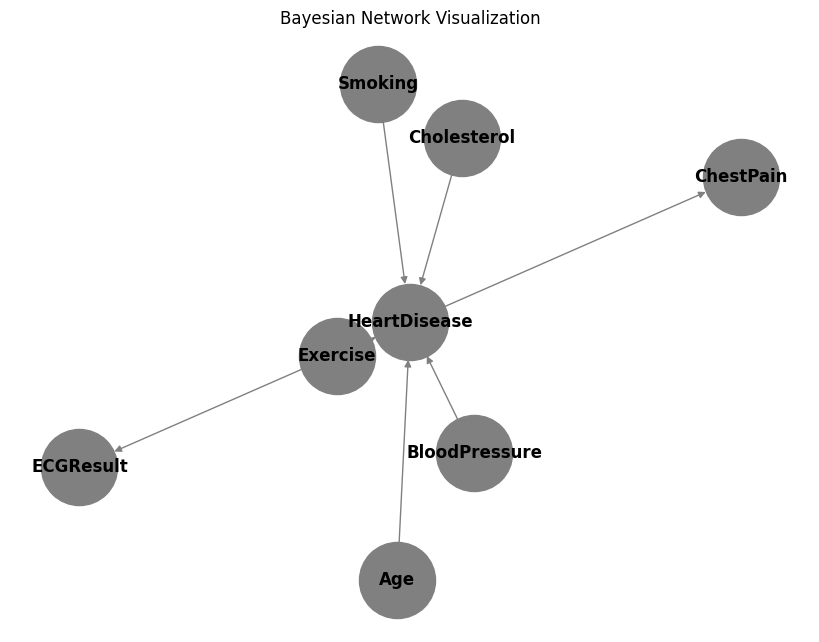

In [12]:
edges = model.edges()
nx_graph = nx.DiGraph()
nx_graph.add_edges_from(edges)

plt.figure(figsize=(8, 6))
nx.draw(nx_graph, with_labels=True, node_color='gray', node_size=3000, font_size=12, font_weight='bold', edge_color='gray')
plt.title("Bayesian Network Visualization")
plt.show()

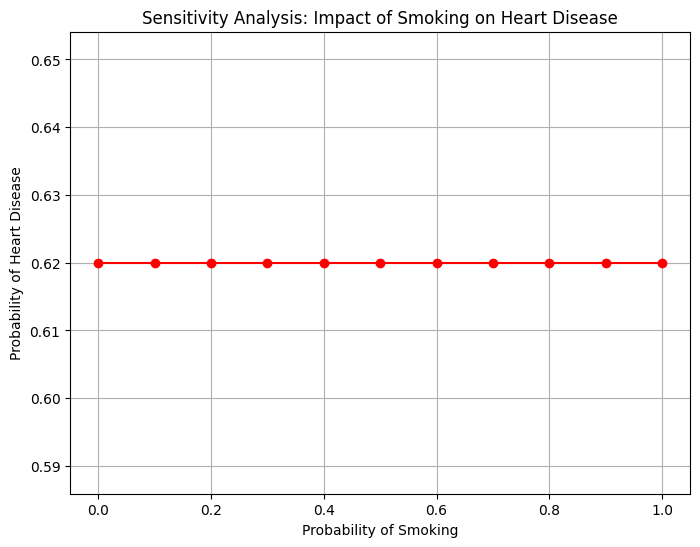

In [10]:
infer = VariableElimination(model)

smoking_probabilities = np.linspace(0, 1, 11)
heart_disease_probs = []

for prob in smoking_probabilities:
    cpd_smoking = TabularCPD(variable='Smoking', variable_card=2, values=[[1 - prob], [prob]])
    model.add_cpds(cpd_smoking)
    model.check_model()

    result = infer.query(variables=['HeartDisease'], evidence={'Age': 1, 'Cholesterol': 1, 'BloodPressure': 1})
    heart_disease_probs.append(result.values[1])

plt.figure(figsize=(8, 6))
plt.plot(smoking_probabilities, heart_disease_probs, marker='o', color='r')
plt.title('Sensitivity Analysis: Impact of Smoking on Heart Disease')
plt.xlabel('Probability of Smoking')
plt.ylabel('Probability of Heart Disease')
plt.grid(True)
plt.show()